In [2]:
import numpy as np
import glob
import pandas as pd
import geopandas as gpd
import xarray as xr
import os.path as osp
from matplotlib import pyplot as plt
from geopy.distance import geodesic
from shapely import geometry
import networkx as nx
from matplotlib import cm
import pickle5 as pickle
from yaml import Loader, load
import seaborn as sb

In [3]:
dp = '/home/fiona/birdMigration/data/raw/radar/fall/2015'
files = glob.glob(osp.join(dp, '*.nc'))
data = {}
start = f'2015-08-01 12:00:00'
end = f'2015-11-15 12:00:00'
t_range = pd.date_range(start, end, freq='1H')
for f in files:
    ds = xr.open_dataset(f)
    radar = ds.source
    radar = (radar[:2]+radar[-3:]).lower()
    ds = ds.sel(time=slice(start, end)).resample(time='1H', skipna=True).reduce(np.nanmean)
    data[radar] = ds.reindex({'time': t_range})

/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)
/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)
/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)
/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)
/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)
/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)
/home/fiona/anaconda3/

In [4]:
def compute_flux(dens, ff, dd, alpha, l):
    # compute number of birds crossing transect of length 'l' [km] and angle 'alpha' per hour
    mtr = dens * ff * np.cos(np.deg2rad(dd - alpha))
    flux = mtr * l * 3.6
    return flux

def compute_angle(coord1, coord2):
    # coords should be in lonlat crs
    y = coord2[0] - coord1[0]
    x = coord2[1] - coord1[1]

    rad = np.arctan2(y, x)
    deg = np.rad2deg(rad)
    deg = (deg + 360) % 360

    return deg

In [20]:
data['demem'][['u', 'v']].resample(time='1H').reduce(np.nanmean)

<xarray.Dataset>
Dimensions:  (lat: 1, lon: 1, time: 2545)
Coordinates:
  * time     (time) datetime64[ns] 2015-08-01T12:00:00 ... 2015-11-15T12:00:00
  * lon      (lon) float64 10.22
  * lat      (lat) float64 48.04
Data variables:
    u        (time, lon, lat) float32 nan nan nan nan nan ... nan nan nan nan
    v        (time, lon, lat) float32 nan nan nan nan nan ... nan nan nan nan

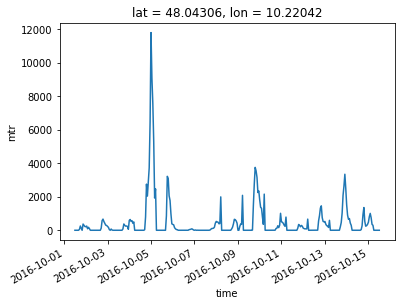

In [104]:
data['demem'].mtr.plot()

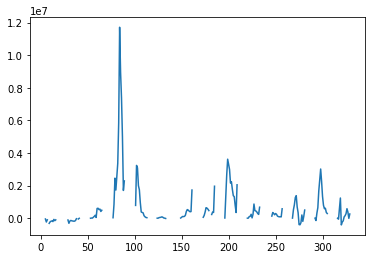

In [105]:
ds = data['demem']
fluxes = compute_flux(ds.vid.values, ds.ff.values, ds.dd.values, 230, 1000)
plt.plot(fluxes.flatten())

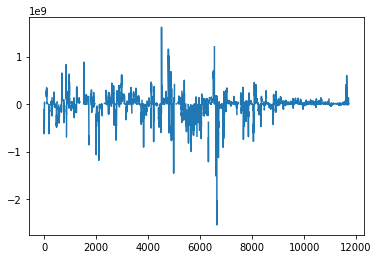

In [24]:
ds = data['DE/MEM']
fluxes = compute_flux(ds.vid.values, ds.ff.values, ds.dd.values, 140, 1000)
plt.plot(fluxes.flatten())

In [5]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

In [6]:
G_new = nx.DiGraph()
G_new.add_nodes_from(list(G.nodes(data=True)))

for i, j, e_data in G.edges(data=True):
    ri = G.nodes[i]['radar']
    rj = G.nodes[j]['radar']
    angle = e_data['angle']
    length = e_data['face_length']
    
    if ri in data and not rj in data:
        dsi = data[ri]
        dsj = data[ri]
    elif ri not in data and rj in data:
        dsi = data[rj]
        dsj = data[rj]
    elif ri in data and rj in data:
        dsi = data[ri]
        dsj = data[rj]
    else:
        continue

    T = 5
    if len(dsi.vid) == len(dsj.vid):
        vid_interp = (dsi.vid.values.flatten() + dsj.vid.values.flatten()) / 2
        dd_interp = ((dsi.dd.values.flatten() + 360) % 360 + (dsj.dd.values.flatten() + 360) % 360) / 2
        ff_interp = (dsi.ff.values.flatten() + dsj.ff.values.flatten()) / 2
        flux_i = compute_flux(dsi.vid.values, dsi.ff.values, (dsi.dd.values + 360) % 360, angle, length).flatten()[:T]
        flux_j = compute_flux(dsj.vid.values, dsj.ff.values, (dsj.dd.values + 360) % 360, angle, length).flatten()[:T]

        flux_interp  = np.nanmean(compute_flux(vid_interp, ff_interp, dd_interp, angle, length))
        if flux_interp > 0:
            G_new.add_edge(i, j, flux=flux_interp)

#         print((i, j), angle, flux_i, flux_j)
#         print((i, j), angle, flux_interp, (flux_i + flux_j)/2)
#         print((i, j), (dsi.dd.values.flatten()[:T] + 360) % 360, (dsj.dd.values.flatten()[:T] + 360) % 360)
#         print((i, j), dsi.ff.values.flatten()[:T], dsj.ff.values.flatten()[:T])

        

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in remainder
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in remainder
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in remainder


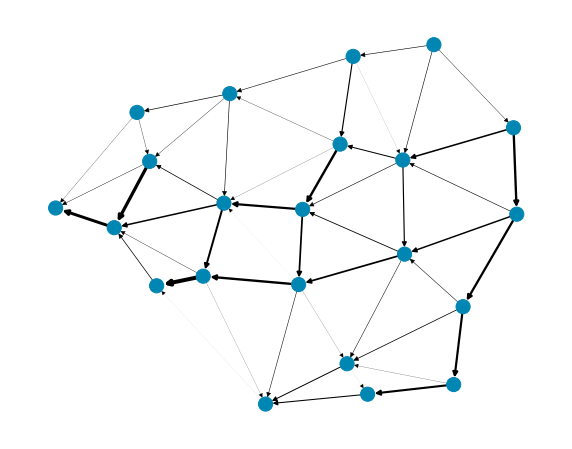

In [7]:
pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
cmap = cm.get_cmap('YlOrBr')
edge_widths = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
edge_widths /= 0.25 * edge_widths.max()
node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
fig, ax = plt.subplots(figsize=(10,8))
options = {
    'arrowsize': 30,
}
nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, options={'arrowsize': edge_widths*100})

In [178]:
total_fluxes = {n : 0 for n in G_new.nodes()}
for i, j, e in G_new.edges(data=True):
    total_fluxes[i] -= e['flux'] / 6549825
    total_fluxes[j] += e['flux'] / 6549825

In [ ]:
for n, data in G_new.nodes(data=True):
    print(data['radar'], total_fluxes[n])

In [238]:
model_dir = '/home/fiona/birdMigration/results/radar/testing/BirdFluxGraphLSTM/best_settings_evaluate_daytime_fixed_boundary_env_previous_enforce_conservation'
train_dir = '/home/fiona/birdMigration/results/radar/training/BirdFluxGraphLSTM/best_settings_evaluate_daytime_fixed_boundary_env_previous_enforce_conservation'
files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
fluxes = dict()
for r, file in enumerate(files):
    with open(file, 'rb') as f:
        fluxes[r] = pickle.load(f)
        
files = glob.glob(model_dir + "/**/results.csv", recursive = True)
results = pd.read_csv(files[0])

fp = osp.join(train_dir, 'config.yaml')
with open(fp) as f:
    cfg = load(f, Loader=Loader)
bird_scale = cfg['datasource']['bird_scale']

In [239]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)
trial = 0
radars = results.radar.unique()
inferred_fluxes = []
observed_fluxes = []
for i, j, e_data in G.edges(data=True):
    ri = G.nodes[i]['radar']
    rj = G.nodes[j]['radar']
    dsi = data[ri]
    dsj = data[rj]
    angle = e_data['angle']
    length = e_data['face_length']
    
    vid_interp = (dsi.vid.values.flatten() + dsj.vid.values.flatten()) / 2
    dd_interp = ((dsi.dd.values.flatten() + 360) % 360 + (dsj.dd.values.flatten() + 360) % 360) / 2
    ff_interp = (dsi.ff.values.flatten() + dsj.ff.values.flatten()) / 2
    flux_interp  = compute_flux(vid_interp, ff_interp, dd_interp, angle, length)
        
    for nidx, f in fluxes[trial].items():
        tidx = results.query(f'seqID == {nidx} & trial == {trial} & radar == "{ri}"').tidx.values
        mask = results.query(f'seqID == {nidx} & radar == "{ri}" | radar == "{rj}"').groupby('horizon').night.all().values

        inferred_fluxes.append(f[i, j, mask])
        observed_fluxes.append(flux_interp[tidx[mask]])
        

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in remainder


In [240]:
inferred_fluxes = np.concatenate([i.detach().numpy() for i in inferred_fluxes])
observed_fluxes = np.concatenate(observed_fluxes)

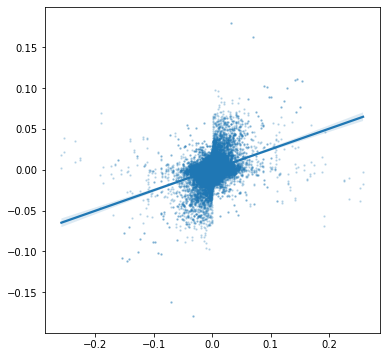

In [241]:
fig, ax = plt.subplots(figsize=(6,6))
sb.regplot(observed_fluxes / bird_scale, inferred_fluxes, scatter=True, ci=95, ax=ax, scatter_kws={'alpha': 0.2, 's': 2})

In [232]:
model_dir = '/home/fiona/birdMigration/results/radar/testing/AttentionGraphLSTM/best_settings_evaluate_daytime_max_dist300_without_bezav'
train_dir = '/home/fiona/birdMigration/results/radar/training/AttentionGraphLSTM/best_settings_evaluate_daytime_max_dist300_without_bezav'
files = glob.glob(model_dir + "/**/attention_weights_*.pickle", recursive = True)
attention = dict()
for r, file in enumerate(files):
    with open(file, 'rb') as f:
        attention[r] = pickle.load(f)
        
files = glob.glob(model_dir + "/**/results.csv", recursive = True)
results = pd.read_csv(files[0])

fp = osp.join(train_dir, 'config.yaml')
with open(fp) as f:
    cfg = load(f, Loader=Loader)
bird_scale = cfg['datasource']['bird_scale']

In [236]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/max_dist_dummy_radars=0_exclude=[bezav]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/max_dist_dummy_radars=0_exclude=[bezav]/radar/fall/2015/G_max_dist=300.gpickle'
G = nx.read_gpickle(G_path)
trial = 0
radars = results.radar.unique()
inferred_fluxes = []
observed_fluxes = []
for i, j, e_data in G.edges(data=True):
    ri = G.nodes[i]['radar']
    rj = G.nodes[j]['radar']
    dsi = data[ri]
    dsj = data[rj]
    angle = e_data['angle']
    length = 1
    
    vid_interp = (dsi.vid.values.flatten() + dsj.vid.values.flatten()) / 2
    dd_interp = ((dsi.dd.values.flatten() + 360) % 360 + (dsj.dd.values.flatten() + 360) % 360) / 2
    ff_interp = (dsi.ff.values.flatten() + dsj.ff.values.flatten()) / 2
    flux_interp  = compute_flux(vid_interp, ff_interp, dd_interp, angle, length)
        
    for nidx, a in attention[trial].items():
        tidx = results.query(f'seqID == {nidx} & trial == {trial} & radar == "{ri}"').tidx.values
        mask = results.query(f'seqID == {nidx} & radar == "{ri}" | radar == "{rj}"').groupby('horizon').night.all().values

        inferred_fluxes.append(a[j, i, mask])
        observed_fluxes.append(flux_interp[tidx[mask]])
        

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in remainder


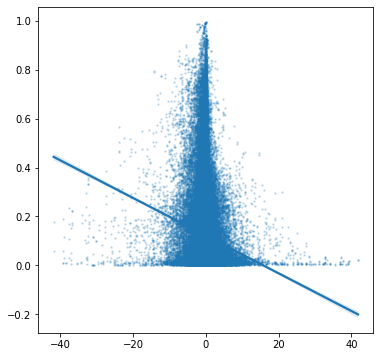

In [237]:
inferred_fluxes = np.concatenate([i.detach().numpy() for i in inferred_fluxes])
observed_fluxes = np.concatenate(observed_fluxes)

fig, ax = plt.subplots(figsize=(6,6))
sb.regplot(observed_fluxes / bird_scale, inferred_fluxes, scatter=True, ci=95, ax=ax, scatter_kws={'alpha': 0.2, 's': 2})